### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver
env=CabDriver()

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
Time_matrix[1][2][23][6]


8.0

#### Tracking the state-action pairs for checking convergence


In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01   
        self.epsilon_max = 1
        self.epsilon = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36) 
        
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)

        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
    
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)

        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])   
    

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets 
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model
    
    def train_model(self): 
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state,isterminal = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                done.append(isterminal)
                update_output[i] = next_state
                
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                next_possible_actions_index,_ = env.requests(update_output[i])
                next_possible_actions_index.append(0)
                if not done[i]:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(np.array([target_qval[i][j] for j in next_possible_actions_index]))
                else:
                    target[i][actions[i]] = rewards[i]
                        
                # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
        
    def save(self, name):
        self.model.save(name)
        
    def append_sample(self, state, action, reward, next_state,isterminal):
        self.memory.append((state, action, reward, next_state,isterminal))
        
    def get_action(self, state,episode):
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
        possible_actions_index,actions = env.requests(env.state_encod_arch1(state)) # Find possible action indexes and append 0
        possible_actions_index.append(0)
#         print("possible_actions_index",possible_actions_index)
#         print("actions",actions)
        if np.random.rand() <= self.epsilon:
            return random.sample(possible_actions_index,1)[0]
        else:
            state = (env.state_encod_arch1(state)).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            return np.where(q_value[0] == np.max(np.array([q_value[0][i] for i in possible_actions_index])))[0][0]

In [6]:
Episodes = 50
threshold = 5       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)

In [7]:
# action_space = [[i,j] for i in range(5) for j in range(5) if (i!=j) or ((i==0) and (j==0))] 
# len(action_space)

### DQN block

In [8]:
start_time = time.time()
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    initial_state = env.state_init    #for the purpose of tracking reward
    curr_state = env.state_init 
#     add_to_dict(curr_state)
    reward = None
 
    total_reward = 0
    isterminal=False
    

    #Call the DQN agent
    dqnagent = DQNAgent(36,21)
    terminal_time=0
    loop=0
    
    while isterminal != True:      
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss 
        curr_action = dqnagent.get_action(curr_state,episode)
        next_state,total_time = env.next_state_func(curr_state, env.action_space[curr_action],Time_matrix)
        terminal_time=terminal_time+total_time
        reward=env.reward_func(curr_state, env.action_space[curr_action], Time_matrix)
#         print("current state {0}, current action index {1}, current action {2}, next state {3}".format(curr_state,curr_action,env.action_space[curr_action],next_state))
        
        if terminal_time > 24*30:
            isterminal=True
            dqnagent.append_sample(env.state_encod_arch1(curr_state), curr_action, reward, env.state_encod_arch1(next_state),isterminal)            
        else:
            dqnagent.append_sample(env.state_encod_arch1(curr_state), curr_action, reward, env.state_encod_arch1(next_state),isterminal)            
            
        dqnagent.train_model()
        
        curr_state=next_state

        total_reward += reward
        
        loop+= 1
        
    # every episode:
    print("episode {0}, reward per episode {1}, memory_length {2}, epsilon {3}, time {4}, rides {5}".format(episode,
                                                                         total_reward,
                                                                         len(dqnagent.memory),
                                                                         dqnagent.epsilon,terminal_time,loop))
     
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % threshold == 0):
        dqnagent.save_tracking_states() 
    
   
    # every few episodes:
    if episode % 2000 == 0:
        print("Saving Model {}".format(episode))
        # save model weights
        save_obj(dqnagent.model, name="model_weights")
              

elapsed_time = time.time() - start_time
print(elapsed_time)
        

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

episode 0, reward per episode -137.0, memory_length 150, epsilon 1.0, time 724.0, rides 150
Saving Model 0
episode 1, reward per episode -401.0, memory_length 153, epsilon 0.37786092411182526, time 730.0, rides 153
episode 2, reward per episode -142.0, memory_length 144, epsilon 0.1466885449377839, time 734.0, rides 144
episode 3, reward per episode -23.0, memory_length 141, epsilon 0.06079027722859995, time 721.0, rides 141
episode 4, reward per episode -311.0, memory_length 147, epsilon 0.02887248314869552, time 721.0, rides 147
episode 5, reward per episode -202.0, memory_length 159, epsilon 0.017012574839761596, time 728.0, rides 159
episode 6, reward per episode 12.0, memory_length 167, epsilon 0.012605709354503069, time 723.0, rides 167
episode 7, reward per episode -212.0, memory_length 171, epsilon 0.010968220859711442, time 721.0, rides 171
episode 8, reward per episode 196.0, memory_length 146, 

### Tracking Convergence

In [15]:
# total_reward_sample = [total_reward[i] for i in range(len(total_reward)) if (i % 4 == 0)]
# plt.title('Rewards per episode')
# xaxis = np.asarray(range(0, len(total_reward_sample)))
# plt.plot(xaxis,np.asarray(total_reward_sample))
# plt.show()

In [9]:
dqnagent.states_tracked

[0.0]

In [10]:
state_tracked_sample = [dqnagent.states_tracked[i] for i in range(len(dqnagent.states_tracked)) if dqnagent.states_tracked[i] < 1000]

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  after removing the cwd from sys.path.


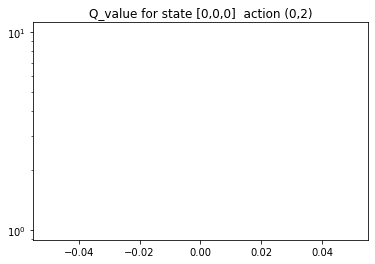

In [11]:
# plotting q value convergence for state action pairs
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(dqnagent.states_tracked)))
plt.semilogy(xaxis,np.asarray(dqnagent.states_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [12]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

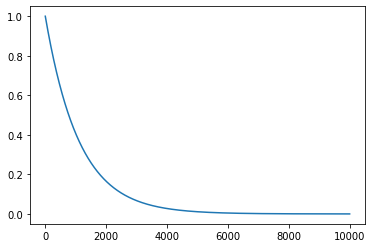

In [13]:
plt.plot(time, epsilon)
plt.show()